# SafeNSound: Initial Log Scaled Mel-Spectrogram Development

In [15]:
import os
import joblib

import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import librosa as lb
# import librosa.display as ld
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
# import sounddevice as sd
from sklearn.model_selection import train_test_split

In [16]:
EMERGENCY_PATH = os.path.join("..", "datasets", "emergency")
ALARMING_PATH = os.path.join("..", "datasets", "alarming")
NORMAL_PATH = os.path.join("..", "datasets", "non-emergency")


def load_audio_files(directory, filename):
    if not os.path.exists(directory):
        raise FileNotFoundError(f"Directory {directory} does not exist.")

    if filename.endswith('.wav'):
        file_path = os.path.join(directory, filename)
        try:
            wav, sr = lb.load(file_path, sr=16000, mono=True)
            ##wav = tf.convert_to_tensor(wav, dtype=tf.float32)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    return wav, sr


In [ ]:
def log_scaled_melspectrogram(audio, sample_rate, hop_length=200, frame_ms=25, n_mels=64, max_len=320):
    frame_length = int(sample_rate * frame_ms / 1000)
    n_fft = 1 << (frame_length - 1).bit_length()

    melspectrogram = lb.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    melS_dB = lb.power_to_db(melspectrogram, ref=np.max)

    if melS_dB.shape[1] < max_len:
        melS_dB = np.pad(melS_dB, ((0,0),(0, max_len - melS_dB.shape[1])), mode='constant')
    else:
        melS_dB = melS_dB[:, :max_len]

    S_norm = (melS_dB - melS_dB.mean()) / (melS_dB.std() + 1e-6)
    # melS_dB = melS_dB[..., np.newaxis]
    delta = lb.feature.delta(S_norm)
    delta2 = lb.feature.delta(S_norm, order=2)

    features = np.stack([S_norm, delta, delta2], axis=-1).astype(np.float32)

    return features

In [18]:
def augment_audio(audio, sample_rate):
    augmented = [audio]

    audio_stretched = lb.effects.time_stretch(audio, rate=0.8)
    augmented.append(audio_stretched)

    noise = np.random.normal(0, 0.003, audio.shape)
    audio_noise = audio + noise
    augmented.append(audio_noise)
    
    audio_high_pitch = lb.effects.pitch_shift(audio, sr=sample_rate, n_steps=2)
    audio_low_pitch = lb.effects.pitch_shift(audio, sr=sample_rate, n_steps=-2)
    augmented.append(audio_high_pitch)
    augmented.append(audio_low_pitch)

    noise_bg = np.random.normal(0, 0.001, audio.shape)
    audio_bg = audio + noise_bg
    augmented.append(audio_bg)

    audio_quiet = audio*0.7
    audio_loud = audio*1.3
    augmented.append(audio_quiet)
    augmented.append(audio_loud)

    return augmented

In [23]:
X = []
y = []
labels = {"emergency": 2, "alarming": 1, "non-emergency": 0}
file_label_pairs = []

for label, idx in labels.items():
    main_path = EMERGENCY_PATH if label == "emergency" else ALARMING_PATH if label == "alarming" else NORMAL_PATH if label == "non-emergency" else None
    if main_path is None:
        print(f"Warning: No valid path for label {label}. Skipping...")
        continue

    folder = f"{main_path}"

    if not os.path.exists(folder):
        print(f"Warning: Directory {folder} does not exist. Skipping...")
        continue

    for file in os.listdir(folder):
        if file.endswith(".wav"):
            file_label_pairs.append((os.path.join(folder, file), idx))
            
paths = [p for p,_ in file_label_pairs]
labs  = [l for _,l in file_label_pairs]

In [24]:
train_paths, temp_paths, train_labs, temp_labs = train_test_split(paths, labs, test_size=0.3, stratify=labs, random_state=42)
val_paths, test_paths, val_labs, test_labs = train_test_split(temp_paths, temp_labs, test_size=0.5, stratify=temp_labs, random_state=42)

train_pairs = list(zip(train_paths, train_labs))
val_pairs   = list(zip(val_paths,  val_labs))
test_pairs  = list(zip(test_paths, test_labs))

In [25]:
def gen(pairs):
    for fp, idx in pairs:
        wav, sr = lb.load(fp, sr=16000, mono=True)
        for aug in augment_audio(wav, sr):
            feat = log_scaled_melspectrogram(aug, sr)  # (64, 320, 3)
            yield feat, keras.utils.to_categorical(idx, num_classes=3)

In [ ]:
spec = (tf.TensorSpec(shape=(64, 320, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(3,), dtype=tf.float32))

train_ds = tf.data.Dataset.from_generator(lambda: gen(train_pairs), output_signature=spec)\
                        .shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_generator(lambda: gen(val_pairs), output_signature=spec)\
                        .batch(32).prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_generator(lambda: gen(test_pairs), output_signature=spec)\
                        .batch(32).prefetch(tf.data.AUTOTUNE)

In [27]:
def build_cnn(input_shape=(64, 320, 3), num_classes=3):
    model = models.Sequential([
        # Conv Block 1
        layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.3),

        # Conv Block 2
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.3),

        # Conv Block 3
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.3),

        # Flatten + Dense
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [40]:
input_shape = X_train.shape[1:]
print("Input shape:", input_shape)

model = build_cnn(input_shape, num_classes=3)
model.summary()

Input shape: (64, 320, 3)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 64, 320, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64, 320, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 32, 160, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32, 160, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 160, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32, 160, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 16, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 80, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 16, 80, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 8, 40, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 8, 40, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     5,243,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,337,539 (20.36 MB)

 Trainable params: 5,337,091 (20.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [41]:
history = model.fit(train_ds, epochs=5, validation_data=val_ds)
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)

Epoch 1/5
    228/Unknown 210s 813ms/step - accuracy: 0.7470 - loss: 3.0706

c:\Users\Acer\Documents\GitHub\SafeNSound-An-IoT-Based-Distress-Signals-Detection-for-Semi-private-Rooms-using-Sound-Sensor\myenv\lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


228/228 ━━━━━━━━━━━━━━━━━━━━ 242s 952ms/step - accuracy: 0.7982 - loss: 1.1186 - val_accuracy: 0.4654 - val_loss: 8.9659
Epoch 2/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 227s 908ms/step - accuracy: 0.8655 - loss: 0.3132 - val_accuracy: 0.5365 - val_loss: 3.2859
Epoch 3/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 222s 896ms/step - accuracy: 0.9011 - loss: 0.2277 - val_accuracy: 0.8577 - val_loss: 0.7416
Epoch 4/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 223s 903ms/step - accuracy: 0.9129 - loss: 0.1990 - val_accuracy: 0.8673 - val_loss: 0.5625
Epoch 5/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 223s 905ms/step - accuracy: 0.9238 - loss: 0.1698 - val_accuracy: 0.8731 - val_loss: 0.7055
49/49 ━━━━━━━━━━━━━━━━━━━━ 29s 590ms/step - accuracy: 0.9122 - loss: 0.4446
Test accuracy: 0.9121794700622559


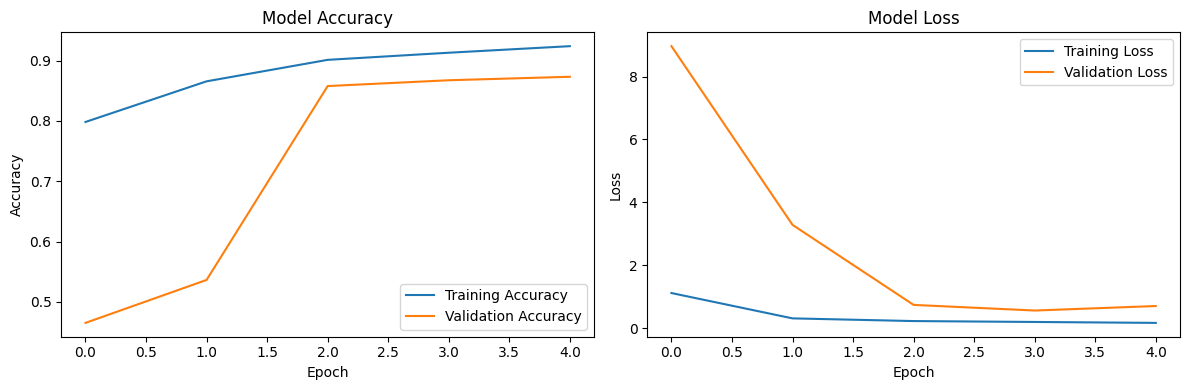

In [42]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [44]:
model.save('lsms_cnn_model.keras')